### Model Benchmarking

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load Data hasil Feature Engineering
df = pd.read_csv('../Data/Wind_Data_Features.csv', parse_dates=['Timestamp'])
df = df.set_index('Timestamp')

# 2. Tentukan Fitur (X) dan Target (y)
# Fitur: lag, cyclical (sin/cos), dan komponen u/v
features = [col for col in df.columns if 'lag' in col or 'sin' in col or 'cos' in col or 'u' in col or 'v' in col]
X = df[features]
y = df['target_3h']

# 3. Splitting Data Spesifik (Full 2023 untuk Test Set)
# Train: 2019 - 2022
X_train = X.loc['2019-01-01':'2022-12-31']
y_train = y.loc['2019-01-01':'2022-12-31']

# Test: Jan - Des 2023
X_test = X.loc['2023-01-01':'2023-12-31']
y_test = y.loc['2023-01-01':'2023-12-31']

print(f"Jumlah data Training: {len(X_train)} jam")
print(f"Jumlah data Testing : {len(X_test)} jam (Tahun 2023)")

# 4. Inisialisasi & Training Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

print("\nMelatih Random Forest...")
rf_model.fit(X_train, y_train)

print("Melatih XGBoost...")
xgb_model.fit(X_train, y_train)

# 5. Prediksi
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# 6. Evaluasi Metrik
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R2   : {r2:.2f}\n")

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")

Jumlah data Training: 35062 jam
Jumlah data Testing : 8754 jam (Tahun 2023)

Melatih Random Forest...
Melatih XGBoost...
--- Random Forest ---
MAE  : 1.46
RMSE : 1.88
R2   : 0.27

--- XGBoost ---
MAE  : 1.39
RMSE : 1.80
R2   : 0.33



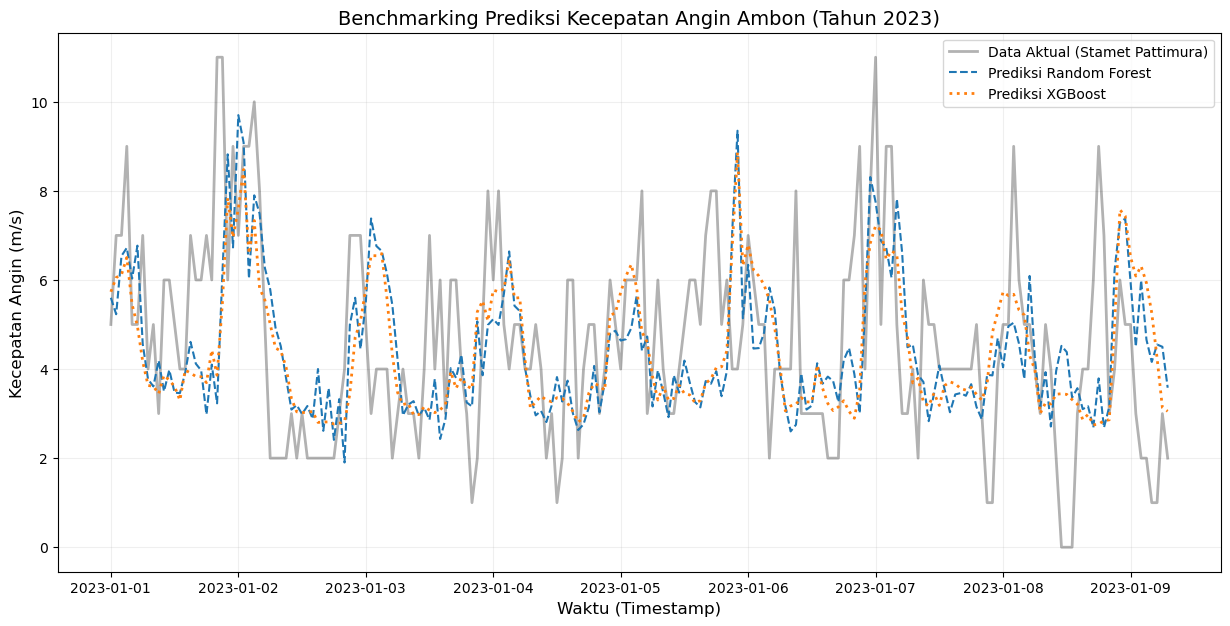

In [7]:
import matplotlib.pyplot as plt

# Plotting hasil untuk visualisasi (Sampel 200 jam pertama tahun 2023)
plt.figure(figsize=(15, 7))

# Data Aktual (Garis Hitam Transparan)
plt.plot(y_test.index[:200], y_test.values[:200], label='Data Aktual (Stamet Pattimura)', color='black', alpha=0.3, linewidth=2)

# Prediksi Random Forest (Garis Putus-putus Biru)
plt.plot(y_test.index[:200], rf_pred[:200], label='Prediksi Random Forest', linestyle='--', color='tab:blue')

# Prediksi XGBoost (Garis Titik-titik Oranye)
plt.plot(y_test.index[:200], xgb_pred[:200], label='Prediksi XGBoost', linestyle=':', color='tab:orange', linewidth=2)

# Labeling dan Judul
plt.title('Benchmarking Prediksi Kecepatan Angin Ambon (Tahun 2023)', fontsize=14)
plt.xlabel('Waktu (Timestamp)', fontsize=12)
plt.ylabel('Kecepatan Angin (m/s)', fontsize=12)

plt.grid(True, alpha=0.2)
plt.legend(loc='upper right')

# Simpan untuk laporan GitHub
plt.savefig('../Data/final_benchmarking_plot_2023.png', dpi=300, bbox_inches='tight')
plt.show()

# 🏆 Laporan Tahap 3: Model Benchmarking & Evaluasi
**Proyek:** Benchmarking Random Forest vs XGBoost - Prediksi Kecepatan Angin Stamet Pattimura Ambon

## 1. Skenario Pengujian (Experimental Setup)
Evaluasi dilakukan menggunakan metode *Time-Series Split* (pemisahan kronologis) untuk menjamin validitas prediksi pada data masa depan. Data tidak diacak (*shuffle*) untuk menjaga urutan waktu.

* **Data Training (Pelatihan):** Periode **2019 s/d 2022** (4 Tahun).
    * Jumlah Data: **35,062 jam**.
* **Data Testing (Pengujian):** Periode **Januari s/d Desember 2023** (1 Tahun Penuh).
    * Jumlah Data: **8,754 jam**.
    * *Tujuan:* Menguji ketangguhan model dalam menghadapi satu siklus musim penuh (Monsun Barat & Timur) di tahun 2023.

## 2. Hasil Evaluasi Kuantitatif
Berikut adalah perbandingan performa antara algoritma **Random Forest** dan **XGBoost** berdasarkan metrik error:

| Metrik Evaluasi | Random Forest | XGBoost 🚀 | Interpretasi |
| :--- | :--- | :--- | :--- |
| **MAE** (Mean Absolute Error) | 1.46 m/s | **1.39 m/s** | Rata-rata prediksi XGBoost lebih akurat (meleset lebih sedikit) dibandingkan RF. |
| **RMSE** (Root Mean Sq. Error) | 1.88 m/s | **1.80 m/s** | XGBoost lebih baik dalam menangani kesalahan besar (penalti outlier). |
| **R² Score** (Akurasi Variansi) | 0.27 | **0.33** | XGBoost mampu menjelaskan 33% pola variasi data, lebih tinggi dari RF (27%). |

> **Analisis:** Secara konsisten, XGBoost mengungguli Random Forest di seluruh metrik pengujian, menunjukkan kemampuan belajar yang lebih baik pada data yang fluktuatif.

## 3. Analisis Visual (Qualitative Analysis)
Grafik di bawah ini menampilkan perbandingan prediksi (*dashed lines*) terhadap data aktual (*solid grey line*) untuk sampel awal tahun 2023.

![Benchmarking Plot](../Data/final_benchmarking_plot_2023.png)

**Observasi Penting:**
1.  **Trend Following:** Kedua model berhasil menangkap pola naik-turun harian (siklus diurnal). Saat angin aktual naik, prediksi model ikut naik.
2.  **Peak Under-prediction:** Pada kejadian angin kencang ekstrem (misal tanggal 2 Januari & 8 Januari dimana kecepatan > 9 m/s), kedua model cenderung memprediksi lebih rendah (*underestimate*) dari kejadian asli. Ini wajar karena model regresi cenderung mengambil nilai "aman" (rata-rata) untuk meminimalkan error global.
3.  **Sensitivitas:** Garis oranye (**XGBoost**) terlihat lebih responsif dan berimpit lebih dekat dengan garis abu-abu (**Aktual**) dibandingkan Random Forest yang kurvanya lebih landai.

## 4. Kesimpulan Akhir
Berdasarkan benchmarking data Stamet Pattimura 2019-2023:
* **Model Terpilih:** **XGBoost**.
* **Alasan:** Memiliki error (MAE/RMSE) yang lebih rendah dan R² Score yang lebih tinggi secara signifikan dibandingkan Random Forest.
* **Rekomendasi:** Meskipun XGBoost lebih baik, nilai R² 0.33 menunjukkan masih banyak variansi alam yang belum tertangkap. Untuk pengembangan selanjutnya, disarankan melakukan *Hyperparameter Tuning* atau menambahkan fitur cuaca lain (seperti Tekanan Udara atau Suhu) untuk meningkatkan akurasi.